In [116]:
#| echo: false
#| hide: true

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

plt.style.use("../style.mplstyle")

<!-- ```{shinylive-python}
#| standalone: true
#| viewerHeight: 1000
#| viewerWidth: 600

from shiny import App, ui, render
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

app_ui = ui.page_fluid(
    ui.input_slider("n", "Number of bins", min=0, max=100, value=40, step=1),
    ui.input_slider("noise", "Noise level", min=0, max=1, value=0.5, step=0.01),
    ui.input_slider("beta", "Slope of regression line", min=-2, max=2, value=0.5, step=0.1),
    ui.output_plot("plot")
)
def server(input, output, session):
    @output
    @render.plot(alt="Average Y by binned X", width=600, height=400)
    def plot():
        rng = np.random.default_rng(42)

        x = rng.normal(size=1000)
        y = input.beta() * x + input.noise() * rng.normal(size=1000)

        data = pd.DataFrame({'x': x, 'y': y})

        sns.scatterplot(x='x', y='y', data=data, alpha=0.3)
        sns.regplot(x='x', y='y', x_bins=input.n(), data=data, ci=None, fit_reg=False, marker="x", color='red')

        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

app = App(app_ui, server)
``` -->

## Inference in Regression

Last lecture we introduced **linear regression** as a way to model the relationship between a response variable $Y$ and some predictor variable $X$. The model assumes that the relationship can be described by a linear equation:

$$ Y = \beta_0 + \beta_1 X + \epsilon $$

where $\beta_0$ is the intercept, $\beta_1$ is the slope, and $\epsilon$ is the error term. The error term captures the variability in $Y$ that cannot be explained by $X$, and we assume it follows a normal distribution with mean 0 (i.e. the deviations from the true regression line are zero on average) and some variance $\sigma^2$.

Throughout this course, we have focused on **sampling variability** and how it affects our ability to make inferences about a population based on a sample. In the context of regression, this means that if we take different samples from the same population, we will get different estimates of the regression coefficients $\beta_0$ and $\beta_1$. This variability is due to the random nature of sampling and the inherent noise in the data. 

The app below illustrates this concept by allowing you to draw samples from a population and see how the estimated regression coefficient ($\hat{\beta}_1$) varies across samples. Notice that the true slope of the regression line is fixed, but the estimated slope varies due to sampling variability. 

You can also see how the stability of the estimate improves as the sample size increases, as well as the confidence implied by the $p$-value of the hypothesis test for the slope ($H_0: \beta_1 = 0$). We will unpack this in more detail shortly.



:::{.column-screen-inset}
```{shinylive-python}
#| standalone: true
#| viewerHeight: 700

from shiny import App, ui, render, reactive
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Fixed population
rng = np.random.default_rng(123)
N_POP = 2000
x_pop = rng.normal(size=N_POP)
true_beta = 0.5
y_pop = true_beta * x_pop + rng.normal(scale=1, size=N_POP)
population = pd.DataFrame({"x": x_pop, "y": y_pop})

app_ui = ui.page_fluid(
    # Title
    ui.div(
        ui.h2("Sampling Variability in Regression Inference"),
        style="text-align:center; margin-bottom:20px; margin-top:20px; font-weight:bold;"
    ),
    # Top row with inputs
    ui.layout_columns(
        ui.input_slider("n", "Sample size", min=5, max=200, value=50, step=5, width="300px"),
        ui.input_numeric("perm", "Number of permutations", value=500, min=100, max=2000, step=100, width="200px"),
        ui.input_action_button("resample", "Draw New Sample", width="200px"),
    ),
    # Second row with two side-by-side plots
    ui.navset_tab(
        ui.nav_panel("Visualization",
            ui.div(
                ui.output_text("coef_text"),
                style="text-align:center; font-size:18px; margin-top:10px; margin-bottom:10px;"
            ),
            ui.layout_columns(
                ui.output_plot("scatter_plot"),
                ui.output_plot("perm_plot"),
            )
        ),
        ui.nav_panel("Permutation Table",
            ui.div(
                "First 50 rows of original sample and first 10 permutations:",
                style="text-align:center; font-size:16px; margin-top:10px; margin-bottom:10px;"
            ),
            ui.output_table("perm_table")
        )
    )
)

def server(input, output, session):
    # ✅ Store the current sample as state
    current_sample = reactive.value(pd.DataFrame())

    # Update sample when button is clicked or sample size changes
    @reactive.effect
    @reactive.event(input.resample, input.n)
    def _():
        idx = rng.choice(len(population), size=input.n(), replace=False)
        current_sample.set(population.iloc[idx])

    # ✅ Compute regression results based on stored sample
    @reactive.calc
    def regression_results():
        data = current_sample()
        if data.empty:
            return {"beta_hat": np.nan, "p_val": np.nan, "perm_coefs": np.array([]), "perm_table": pd.DataFrame()}

        model = smf.ols("y ~ x", data=data).fit()
        beta_hat = model.params["x"]
        p_val = model.pvalues["x"]

        perm_coefs = []
        perm_tables = []
        for i in range(input.perm()):
            y_perm = rng.permutation(data["y"])
            perm_model = smf.ols("y ~ x", data=data.assign(y=y_perm)).fit()
            perm_coefs.append(perm_model.params["x"])

            if i < 10:  # store first 10 permutations for table
                df_perm = pd.DataFrame({"x": data["x"].values, f"y_perm_{i+1}": y_perm})
                perm_tables.append(df_perm[[f"y_perm_{i+1}"]])

        # Merge the first few permutations into one table
        if perm_tables:
            perm_table_df = pd.concat([data[["x", "y"]].reset_index(drop=True)] + perm_tables, axis=1)
        else:
            perm_table_df = pd.DataFrame()
        
        # compute permutation p-value
        perm_coefs = np.array(perm_coefs)
        # two-tailed p-value
        p_val_perm = np.mean(np.abs(perm_coefs) >= np.abs(beta_hat))

        return {
            "beta_hat": beta_hat,
            "p_val": p_val,
            "p_val_perm": p_val_perm,
            "perm_coefs": np.array(perm_coefs),
            "perm_table": perm_table_df
        }

    @output
    @render.text
    def coef_text():
        res = regression_results()
        if np.isnan(res["beta_hat"]):
            return "Click 'Draw New Sample' to begin."
        return f"True slope: {true_beta:.3f}, Estimated slope: {res['beta_hat']:.3f}, Parametric p-value: {res['p_val']:.4f}, Permutation p-value: {res['p_val_perm']:.4f}"

    @output
    @render.plot
    def scatter_plot():
        data = current_sample()
        res = regression_results()

        plt.figure(figsize=(7, 5))
        sns.scatterplot(x="x", y="y", data=population, alpha=0.1, color="gray")

        if not data.empty:
            sns.scatterplot(x="x", y="y", data=data, color="blue", label="Sampled Points")
            x_vals = np.linspace(population["x"].min(), population["x"].max(), 100)
            y_vals = res["beta_hat"] * x_vals + data["y"].mean() - res["beta_hat"] * data["x"].mean()
            plt.plot(x_vals, y_vals, color="red", lw=2, label="Estimated Regression Line")
            # Add true population regression line
            plt.plot(x_vals, true_beta * x_vals, alpha=0.3, color="gray", linestyle="--", label="True Regression Line")
            plt.legend()


        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(population["x"].min(), population["x"].max())
        plt.ylim(population["y"].min(), population["y"].max())
        plt.title("Sampled Points and Fitted Regression Line")

    @output
    @render.plot
    def perm_plot():
        res = regression_results()
        if len(res["perm_coefs"]) == 0:
            plt.figure()
            plt.text(0.5, 0.5, "Click 'Draw New Sample' to start.", ha="center", va="center")
            return

        plt.figure(figsize=(7, 4))
        sns.histplot(res["perm_coefs"], bins=30, kde=False, color="gray")
        plt.axvline(res["beta_hat"], color="red", lw=2, label="Observed β̂")
        plt.axvline(true_beta, color="blue", lw=2, linestyle="--", label="True β")
        plt.xlabel(r"Estimated slope ($\hat{\beta}$)")
        plt.ylabel("Count")
        plt.xlim(min(-1, res["perm_coefs"].min()), max(1, res["perm_coefs"].max()))
        plt.title(r"Null Distribution of $\hat{\beta}$ (Permutation Test)")
        plt.legend()
    @output
    @render.table
    def perm_table():
        res = regression_results()
        df = res["perm_table"]
        if df.empty:
            return pd.DataFrame()
        return df.head(50)  # Only show first 50 rows

app = App(app_ui, server)
```
:::

:::{.callout-note title="Fitting the regression model" collapse="true"}
As in the previous lecture, we use the `statsmodels` library to fit the regression model. 

Under the hood, the app is doing the following:

```python
# Fixed population
rng = np.random.default_rng(123)
N_POP = 2000
x_pop = rng.normal(size=N_POP)
true_beta = 0.5
y_pop = true_beta * x_pop + rng.normal(scale=1, size=N_POP)
population = pd.DataFrame({"x": x_pop, "y": y_pop})
```
This creates a fixed population of 2000 points with a known slope of 0.5. The app then allows you to draw samples from this population and fit a regression model to the sampled data.

More specifically, we subsample the population to create a new sample of size `n`:

```python
idx = rng.choice(len(population), size=n, replace=False)
data = population.iloc[idx]
```
Then we fit the regression model using `statsmodels`:
```python
model = smf.ols('y ~ x', data=data).fit()
    beta_hat = model.params['x']
```
:::


### Hypothesis Testing in Regression

In regression analysis, we often want to test hypotheses about the relationship between the predictor variable $X$ and the response variable $Y$. The most common hypothesis to test is whether the slope of the regression line ($\beta_1$) is different from zero, which would indicate that there is a relationship between $X$ and $Y$.

So we can set up the following hypotheses:
$$
\begin{align*}
H_0:& ~\beta_1 = 0 \quad \text{(no relationship)} \\
H_1:& ~\beta_1 \neq 0 \quad \text{(there is a relationship)}
\end{align*}
$$

We're back in our comfort zone now. How can we simulate the distribution of the estimated slope $\hat{\beta}_1$ under the null hypothesis? We'll use a **permutation test** -- take a shot at implementing it in the code cell below.


::::{.panel-tabset}

## Exercise

```{pyodide}
#| exercise: hypothesis-testing-regression
#| caption: Write a permutation test to simulate the distribution of the estimated slope under the null hypothesis that there is no relationship between X and Y.
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

n = 100
x = rng.normal(size=100)
y = 0.5 * x + 0.5 * rng.normal(size=100)
data = pd.DataFrame({'x': x, 'y': y})
rng = np.random.default_rng(42)

def permutation_test_regression(data, n_permutations=1000, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  # first, fit the regression model (on the original data)
  model = smf.ols('y ~ x', data=data).fit()
  beta_hat = model.params['x']
  
  # TODO: implement the permutation test. 
  # You should be able to return the observed slope, 
  # the array of permuted slopes, and the p-value 
  # associated with the test.
  return {
    "beta_hat": beta_hat,
    "perm_beta_hats": perm_beta_hats,
    "p_val": p_val,
  }

result_dict = permutation_test_regression(data, n_permutations=1000, rng=rng)
print("Observed slope (beta_hat):", result_dict['beta_hat'])
print("Permutation p-value:", result_dict['p_val'])
```

## Hint
::: {.hint exercise="hypothesis-testing-regression"}
To implement the permutation test, you will need to:

1. Fit the regression model to the original data to get the observed slope $\hat{\beta}_1$.
2. For each permutation:
   - Permute the response variable $Y$ to break the relationship with $X$.
   - Fit the regression model to the permuted data.
   - Store the estimated slope $\hat{\beta}_1$ from the permuted data.
3. Compute the p-value as the proportion of permuted slopes that are greater than or equal to the observed slope in absolute value (two-tailed test).

:::

## Solution
::: {.solution exercise="hypothesis-testing-regression"}

```python
def permutation_test_regression(data, n_permutations=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    # first, fit the regression model (on the original data)
    model = sm.ols('y ~ x', data=data).fit()
    beta_hat = model.params['x']
    
    perm_beta_hats = [] # list to store permuted slopes
    for _ in range(n_permutations):
        # permute the response variable y
        # this breaks the relationship between x and y
        y_perm = rng.permutation(data['y'])
        # fit the regression model to the permuted data
        perm_model = sm.OLS(y_perm, X).fit()
        # store the estimated slope
        perm_beta_hats.append(perm_model.params['x'])
    # the slopes from the permuted data are
    # your null distribution
    perm_beta_hats = np.array(perm_beta_hats)
    # compute p-value
    p_val = np.mean(np.abs(perm_beta_hats) >= np.abs(beta_hat))
    
    return {
        "beta_hat": beta_hat,
        "perm_beta_hats": perm_beta_hats,
        "p_val": p_val,
    }
result_dict = permutation_test_regression(data, n_permutations=1000, rng=rng)
print("Observed slope (beta_hat):", result_dict['beta_hat'])
print("Permutation p-value:", result_dict['p_val'])
```
:::
::::


This is precisely the permutation test that generates the null distribution displayed in the app. 

Notice that the permuation test $p$-value is nearly identical to the parametric $p$-value computed by `statsmodels` using the assumption that the errors are normally distributed. 

:::{.callout-note title="Parametric inference in regression" collapse="true"}
The app uses `statsmodels` to compute the regression coefficients and their associated p-values. To get these $p$-values (without doing simulations / randomization), you have to make assumptions about the underlying probability distributions. 

In the linear regression model, the typical assumption is that (as we discussed in the previous lecture) the errors $\epsilon$ are normally distributed. This makes the $Y$ values themselves normal random variables (i.e. $Y \sim \mathcal{N}(\beta_0 + \beta_1 X, \sigma^2)$). This assumption allows us to use the properties of the normal distribution to figure out analytical expressions for the uncertainty in the estimated coefficients (a.k.a. the standard errors) and the $p$-values for hypothesis tests.

The details of the parametric inference are beyond the scope of this course but you are encouraged to take more advanced courses in statistics or econometrics to learn more about it! 
:::


### Confidence Intervals for Regression Coefficients

$p$-values are nice, but they don't tell us the whole story. We might want to get a sense of the range of plausible values for the regression coefficients, because the effect size is important too.

:::{.callout-warning title="Effect Size" collapse="true"}
**Effect size** refers to the magnitude of a quantity you are interested in estimating -- often a difference in averages or a regression coefficient. 

For a simple example, let's go all the way back to coin flips. We saw examples where we tried to estimate the probability of seeing a certain set of outcomes if the coin was fair. We saw that with lots of coin flips, we were able to confidently detect a biased coin. But we saw an example where the coin was **very** biased (only 25% heads). What if the coin was just a little biased (say 51% heads)? This is a much smaller effect size, and it would be harder to detect with the same number of coin flips -- but with enough flips we could still detect it. Is a 1% difference in probability of heads worth fighting over? What about a 0.1% difference? 

This comes up a lot in scientific research. Say you are testing a new drug and you find that it reduces symptoms by 5% compared to a placebo. Is that a meaningful effect? What if the drug only reduces symptoms by 0.5%? Producing the drug might be very expensive, so a small effect size might not be worth the cost (or possibly the risk of side effects).

::: 

In addition to hypothesis testing, we can also use bootstrapping to construct confidence intervals for the regression coefficients. 

Here's some code that does this:

In [43]:
# | code-fold: show

import statsmodels.formula.api as sm
import pandas as pd
import numpy as np


def bootstrap_regression_ci(data, x_col, y_col, n_bootstraps=1000, alpha=0.05):
    n = len(data)
    coefs = []
    for _ in range(n_bootstraps):
        sample = data.sample(n, replace=True)  # <1>
        model = sm.ols(f"{y_col} ~ {x_col}", data=sample).fit()  # <2>
        coefs.append(model.params[x_col])  # <3>
    coefs = np.array(coefs)
    lower_bound = np.percentile(coefs, 100 * alpha / 2)  # <4>
    upper_bound = np.percentile(coefs, 100 * (1 - alpha / 2))
    return coefs, lower_bound, upper_bound


rng = np.random.default_rng(123)
# Generate synthetic data
x = rng.normal(size=100)
y = 1.5 * x + 2 + rng.normal(size=100)
data = pd.DataFrame({"x": x, "y": y})

model = sm.ols("y ~ x", data=data).fit()  # <5>

bootstrap_coefs, lower_bound, upper_bound = bootstrap_regression_ci(
    data, "x", "y", n_bootstraps=1000
)
print("#" * 40)
print(f"Bootstrap CI for slope: [{lower_bound:.3f}, {upper_bound:.3f}]")
print("#" * 40)
model.summary(slim=True)  # <6>


########################################
Bootstrap CI for slope: [1.360, 1.771]
########################################


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.696
No. Observations:                 100   F-statistic:                     227.5
Covariance Type:            nonrobust   Prob (F-statistic):           2.71e-27
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0933      0.093     22.569      0.000       1.909       2.277
x              1.5567      0.103     15.084      0.000       1.352       1.761
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Bootstrap the data to create multiple samples (same size as the original sample, sampled with replacement).
2. Fit the regression model to each bootstrap sample.
3. Store the estimated coefficients from each bootstrap sample.
4. Compute the confidence intervals based on the distribution of the bootstrap estimates.
5. Fit the regression model to the original data to get the point estimates.
6. Print statsmodels summary table with the confidence intervals.

The summary table has lots of extra information you can ignore for now, but the key part is the `coef` column which contains the point estimates of the regression coefficients, and the `[0.025, 0.975]` columns which contain the lower and upper bounds of the 95% confidence intervals.

We also printed the bootstrapped confidence intervals, and you can see that they are very similar to the ones computed by `statsmodels` using the normality assumption.

Still confused? Try the following app to visualize what's going on:

:::{.column-screen-inset}
```{shinylive-python}
#| standalone: true
#| viewerHeight: 950

from shiny import App, ui, render, reactive
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

rng = np.random.default_rng(123)
N_POP = 1000

app_ui = ui.page_fluid(
    ui.layout_sidebar(
        ui.sidebar(
            ui.input_slider("beta", "True Slope (β)", min=-2, max=2, value=0.5, step=0.1),
            ui.input_slider("sigma", "Noise SD (σ)", min=0.1, max=2.0, value=1.0, step=0.1),
            ui.input_slider("n", "Original Sample Size", min=10, max=500, value=100),
            ui.input_action_button("draw_sample", "Draw Original Sample"),
            ui.input_action_button("bootstrap1", "Bootstrap 1x", disabled=True),
            ui.input_action_button("bootstrap10", "Bootstrap 10x", disabled=True),
            ui.input_action_button("bootstrap100", "Bootstrap 100x", disabled=True),
            ui.input_action_button("reset", "Reset", disabled=True),
        ),
        ui.navset_tab(
            ui.nav_panel("Scatter and Slopes Histogram",
                ui.output_plot("scatter_plot"),
                ui.div(
                    ui.output_text("count_text"),
                    style="text-align:center; font-size:16px; margin-top:10px;"
                ),
                ui.output_plot("hist_plot"),
            ),
            ui.nav_panel("Bootstrapped Regression Lines",
                ui.output_plot("lines_plot"),
            ),
        ),
    )
)

def server(input, output, session):
    original_sample = reactive.value(pd.DataFrame())
    current_bootstrap = reactive.value(pd.DataFrame())
    bootstrap_coefs = reactive.value([])

    # Generate population reactively
    @reactive.calc
    def population():
        x = rng.normal(size=N_POP)
        y = input.beta() * x + input.sigma() * rng.normal(size=N_POP)
        return pd.DataFrame({"x": x, "y": y})

    # Helper to enable/disable buttons
    def set_buttons(enable_bootstrap=False, enable_draw=True, enable_reset=False):
        session.send_input_message("bootstrap1", {"disabled": not enable_bootstrap})
        session.send_input_message("bootstrap10", {"disabled": not enable_bootstrap})
        session.send_input_message("bootstrap100", {"disabled": not enable_bootstrap})
        session.send_input_message("draw_sample", {"disabled": not enable_draw})
        session.send_input_message("reset", {"disabled": not enable_reset})

    @reactive.effect
    def _init_buttons():
        set_buttons(enable_bootstrap=False, enable_draw=True, enable_reset=False)

    # Reset sample & bootstrap whenever population changes
    @reactive.effect
    @reactive.event(input.beta, input.sigma, input.n)
    def _reset_on_population_change():
        original_sample.set(pd.DataFrame())
        current_bootstrap.set(pd.DataFrame())
        bootstrap_coefs.set([])
        set_buttons(enable_bootstrap=False, enable_draw=True, enable_reset=False)

    # Draw original sample
    @reactive.effect
    @reactive.event(input.draw_sample)
    def draw_sample():
        sample = population().sample(n=input.n(), replace=False)
        original_sample.set(sample)
        current_bootstrap.set(pd.DataFrame())
        bootstrap_coefs.set([])
        set_buttons(enable_bootstrap=True, enable_draw=False, enable_reset=True)

    def bootstrap_once():
        sample = original_sample()
        if sample.empty:
            return
        resample = sample.sample(n=len(sample), replace=True)
        current_bootstrap.set(resample)
        model = smf.ols("y ~ x", data=resample).fit()
        bootstrap_coefs.set(bootstrap_coefs() + [(model.params["Intercept"], model.params["x"])])

    # Bootstrap buttons
    @reactive.effect
    @reactive.event(input.bootstrap1)
    def boot1():
        bootstrap_once()

    @reactive.effect
    @reactive.event(input.bootstrap10)
    def boot10():
        for _ in range(10):
            bootstrap_once()

    @reactive.effect
    @reactive.event(input.bootstrap100)
    def boot100():
        for _ in range(100):
            bootstrap_once()

    # Reset button
    @reactive.effect
    @reactive.event(input.reset)
    def reset_all():
        original_sample.set(pd.DataFrame())
        current_bootstrap.set(pd.DataFrame())
        bootstrap_coefs.set([])
        set_buttons(enable_bootstrap=False, enable_draw=True, enable_reset=False)

    # Bootstrap count text
    @output
    @render.text
    def count_text():
        count = len(bootstrap_coefs())
        if count == 0:
            return "No bootstrap samples yet."
        elif count == 1:
            return "1 bootstrap sample drawn."
        else:
            return f"{count} bootstrap samples drawn."

    # Scatter plot
    @output
    @render.plot
    def scatter_plot():
        plt.figure(figsize=(7, 4.5))
        pop = population()

        pop_model = smf.ols("y ~ x", data=pop).fit()
        x_vals = np.linspace(pop["x"].min(), pop["x"].max(), 100)
        y_vals = pop_model.params["Intercept"] + pop_model.params["x"] * x_vals
        plt.plot(x_vals, y_vals, color="gray", lw=2, linestyle=":", label="Population line")

        sample = original_sample()
        if not sample.empty:
            sns.scatterplot(x="x", y="y", data=sample, color="black", alpha=0.4, label="Original sample")
            model = smf.ols("y ~ x", data=sample).fit()
            y_vals_s = model.params["Intercept"] + model.params["x"] * x_vals
            plt.plot(x_vals, y_vals_s, color="black", linestyle="--", label="Original line", alpha=0.7, lw=2)

        boot = current_bootstrap()
        if not boot.empty:
            sns.scatterplot(x="x", y="y", data=boot, color="blue", alpha=0.7, label="Bootstrap sample")
            model_b = smf.ols("y ~ x", data=boot).fit()
            y_vals_b = model_b.params["Intercept"] + model_b.params["x"] * x_vals
            plt.plot(x_vals, y_vals_b, color="blue", lw=2, label="Bootstrap line")

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Population, original sample, and (most recent) bootstrap sample")
        plt.legend()

    # Histogram
    @output
    @render.plot
    def hist_plot():
        coefs = bootstrap_coefs()
        # unpack (Intercept, slope) tuples
        plt.figure(figsize=(7, 3.5))

        if coefs:
            coefs = [coef[1] for coef in coefs]  # extract slopes only
            sns.histplot(coefs, bins=20, color="lightblue", kde=False)
            q_low, q_high = np.quantile(coefs, [0.025, 0.975])
            plt.axvline(q_low, color="purple", linestyle="--", lw=2, label="2.5% Quantile")
            plt.axvline(q_high, color="purple", linestyle="--", lw=2, label="97.5% Quantile")
            plt.fill_betweenx(
                [0, plt.ylim()[1]], q_low, q_high, color="purple", alpha=0.05, label="95% CI"
            )

        sample = original_sample()
        if not sample.empty:
            model_orig = smf.ols("y ~ x", data=sample).fit()
            obs_slope = model_orig.params["x"]
            plt.axvline(obs_slope, color="black", lw=2, label=r"Observed $\hat{\beta}$")

        plt.xlabel("Bootstrap Slope Estimates")
        plt.ylabel("Frequency")
        plt.title(r"Bootstrap distribution of $\hat{\beta}$")
        plt.legend()

    @output
    @render.plot
    def lines_plot():
        plt.figure(figsize=(7, 5))
        x_vals = np.linspace(-3, 3, 100)

        # Draw all bootstrap lines
        for (intercept, slope) in bootstrap_coefs():
            plt.plot(x_vals, intercept + slope * x_vals, color="blue", alpha=0.1)

        # Draw original sample line
        sample = original_sample()
        if not sample.empty:
            m = smf.ols("y ~ x", data=sample).fit()
            plt.plot(x_vals, m.params["Intercept"] + m.params["x"] * x_vals,
                     color="black", lw=2, label="Original Line")

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Bootstrap Regression Lines")
        plt.legend()


app = App(app_ui, server)
```
:::

The bootstrap distribution of the estimated slope $\hat{\beta}_1$ gives us confidence intervals for the slope. See the second panel of the app for a visualization of bootstrapped regression lines (slope and intercept). As you draw more bootstrap samples, you'll see that the regression lines concentrate around the original sample's regression line, but their distribution gives us a sense of the variability in the regression predictions. 

::: {.callout-note title="Prediction Intervals" collapse="true"}
In addition to confidence intervals for the regression coefficients and their associated predictions, one can also try to account for the randomness in the response variable $Y$ itself. That is, in the linear regression model, we assume that the response variable $Y$ is normally distributed around the regression line with some variance $\sigma^2$. 

In other words, the confidence intervals tell us about the variability of our predictions, but not about the variability of the actual response variable $Y$. Prediction intervals aim to capture this additional source of variability by providing a range of values within which we expect future observations to fall, given the same values of the predictor variables.

Details of generating predictions intervals are beyond the scope of this course (for now).
:::

## Multiple Regression

So far, we have only considered *simple linear regression*, where we have one predictor variable $X$ and one response variable $Y$. However, in many real-world scenarios, we have multiple predictor variables that can influence the response variable simultaneously. 

This leads us to **multiple linear regression**, which extends the simple linear regression model to include multiple predictors:
$$ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p + \epsilon $$

where $X_1, X_2, \ldots, X_p$ are the predictor variables, $\beta_0$ is the intercept, $\beta_1, \ldots, \beta_p$ are the slopes for each predictor, and $\epsilon$ is the error term.

In multiple regression, we can still use the same principles of hypothesis testing and confidence intervals.

Let's start off with a simple example of multiple regression using the `statsmodels` library.

We're going to use a dataset with information about students' academic performance in secondary school.^[Paper: Cortez, P (2008) "Using Data Mining to Predict Secondary School Student Performance". Dataset: [https://doi.org/10.24432/C5TG7T](https://doi.org/10.24432/C5TG7T)] The dataset contains various features such as study time, family information, and lifestyle (e.g. how much they go out),and much more. The goal is to predict the final grade of the students in a secondary school course (a numeric value out of 20). There are datasets for two subjects: Mathematics and Portuguese, but we'll focus on the Mathematics dataset.


In [79]:
student_data = pd.read_csv("../data/student-mat.csv", sep=";")
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Here's a breakdown of what the columns in the dataset represent:

```{=html}
<style>
.scrollable-fixed {
  max-height: 400px;  /* Fixed height */
  overflow-y: auto;   /* Vertical scroll */
  overflow-x: auto;   /* Horizontal scroll */
  border: 2px solid #ddd;
  padding: 5px;
  margin: 20px 0;
}
</style>
```

::: {.scrollable-fixed}
| Variable   | Description                                | Type / Values                                                             |
|------------|--------------------------------------------|---------------------------------------------------------------------------|
| school     | Student's school                           | GP = Gabriel Pereira, MS = Mousinho da Silveira                           |
| sex        | Student's sex                              | F = female, M = male                                                      |
| age        | Student's age                              | Numeric (15–22)                                                           |
| address    | Home address type                          | U = urban, R = rural                                                      |
| famsize    | Family size                                | LE3 = ≤3, GT3 = >3                                                        |
| Pstatus    | Parent's cohabitation status               | T = living together, A = apart                                           |
| Medu       | Mother's education                         | 0 = none, 1 = primary, 2 = 5th–9th, 3 = secondary, 4 = higher            |
| Fedu       | Father's education                         | 0 = none, 1 = primary, 2 = 5th–9th, 3 = secondary, 4 = higher            |
| Mjob       | Mother's job                               | teacher, health, services, at_home, other                                |
| Fjob       | Father's job                               | teacher, health, services, at_home, other                                |
| reason     | Reason to choose this school               | home, reputation, course, other                                          |
| guardian   | Student's guardian                         | mother, father, other                                                    |
| traveltime | Home-to-school travel time                 | 1 = <15m, 2 = 15–30m, 3 = 30–60m, 4 = >1h                                |
| studytime  | Weekly study time                          | 1 = <2h, 2 = 2–5h, 3 = 5–10h, 4 = >10h                                   |
| failures   | Number of past class failures              | n if 1≤n<3, else 4                                                       |
| schoolsup  | Extra educational support                  | yes / no                                                                 |
| famsup     | Family educational support                 | yes / no                                                                 |
| paid       | Extra paid classes in the subject          | yes / no                                                                 |
| activities | Extra-curricular activities                | yes / no                                                                 |
| nursery    | Attended nursery school                    | yes / no                                                                 |
| higher     | Wants to take higher education             | yes / no                                                                 |
| internet   | Internet access at home                    | yes / no                                                                 |
| romantic   | With a romantic relationship               | yes / no                                                                 |
| famrel     | Quality of family relationships            | 1 = very bad … 5 = excellent                                             |
| freetime   | Free time after school                     | 1 = very low … 5 = very high                                             |
| goout      | Going out with friends                     | 1 = very low … 5 = very high                                             |
| Dalc       | Workday alcohol consumption                | 1 = very low … 5 = very high                                             |
| Walc       | Weekend alcohol consumption                | 1 = very low … 5 = very high                                             |
| health     | Current health status                      | 1 = very bad … 5 = very good                                             |
| absences   | Number of school absences                  | Numeric (0–93)                                                           |
| G1         | First period grade                         | 0–20                                                                     |
| G2         | Second period grade                        | 0–20                                                                     |
| G3         | Final grade (target variable)              | 0–20                                                                     |
:::

Let's pick a model. If we want to predict the final grade $G3$, then perhaps we can use information about the student's family history to help us. In particular, one might expect that the education level of the parents might be a good predictor of the student's performance (educated parents might be more likely to help with homework, have higher expectations, etc.).

We can fit a multiple regression model with the final grade $G3$ as the response variable and the father's education level $Fedu$ as a predictor.

In [97]:
model = smf.ols("G3 ~ Fedu", data=student_data).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
No. Observations:                 395   F-statistic:                     9.352
Covariance Type:            nonrobust   Prob (F-statistic):            0.00238
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.7967      0.576     15.264      0.000       7.664       9.930
Fedu           0.6419      0.210      3.058      0.002       0.229       1.055
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nice, it looks like a good predictor. Looking at the confidence interval and $p$-value, we see that it is pretty clear there is a nonzero effect of `Fedu` on `G3`. So we're done, right? 

Wrong! There are many other variables in the dataset that could also influence the final grade. Perhaps most obviously, the mother's education level `Medu` could also be important.

Let's take a look at how these variables are related to each other. Below we'll show the correlation matrix between these variables, and then we'll visualize their relationships using pairwise scatterplots.

In [98]:
student_data[["Fedu", "Medu", "G3"]].corr().apply(lambda x: x**2).style.background_gradient(cmap="coolwarm")

,Fedu,Medu,G3
Fedu,1.000000,0.388696,0.023243
Medu,0.388696,1.000000,0.047153
G3,0.023243,0.047153,1.000000


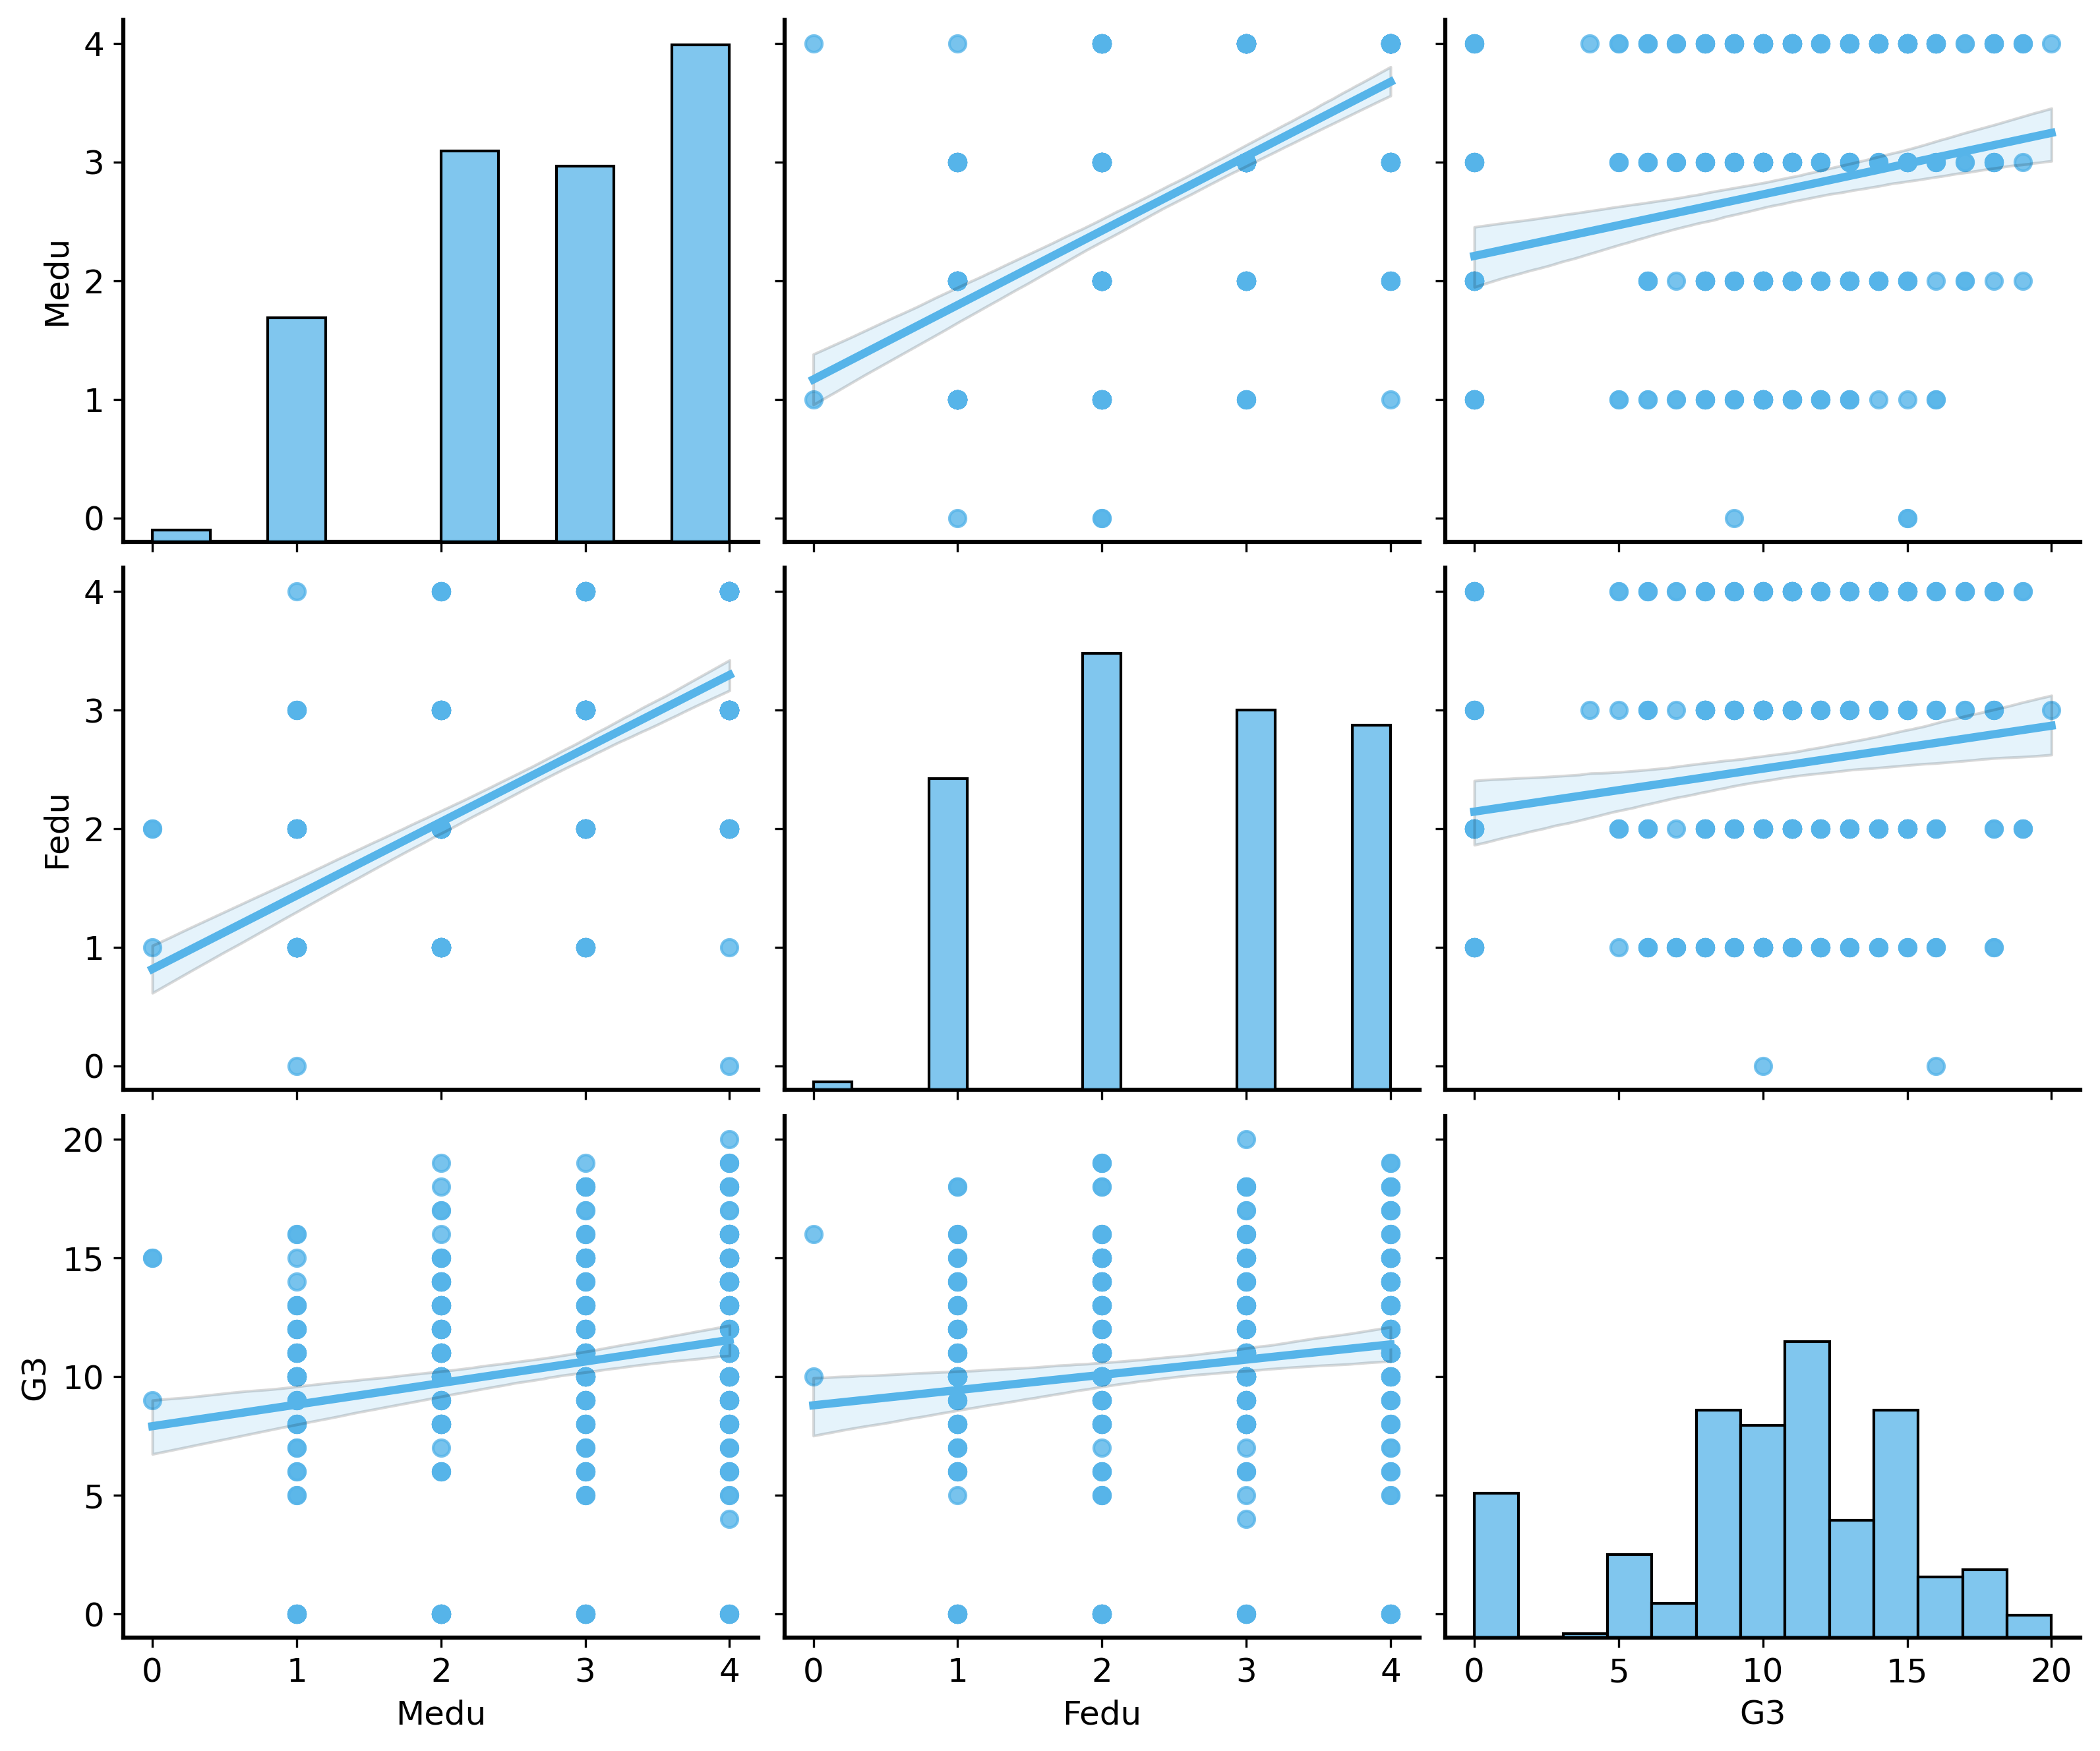

In [101]:
sns.pairplot(student_data, vars=["Medu", "Fedu", "G3"], kind="reg", height=3, aspect=1.2)

Wow, now that we look at the data, we see that `Fedu` and `Medu` are correlated with each other (meaning that students with educated fathers tend to also have educated mothers). And it seems like `Medu` is even more strongly correlated with the final grade `G3` than `Fedu` is.

All of a sudden this is quite complicated. If a student's parents are often both educated, then how can we tell which parent is more important for the student's final grade? We don't know how to disentangle the effects of `Fedu` and `Medu` on `G3` because they are correlated with each other.

This problem is called **multicollinearity**. It occurs when two or more predictor variables in a regression model are highly correlated with each other, making it difficult to determine the individual effect of each predictor on the response variable.

The question we really want to answer is: how much does each predictor contribute to the final grade, after accounting for the other predictors?

Let's think about predicting the final grade `G3` based on the father's education `Fedu`, while accounting for the mother's education `Medu`.

First, we can fit a simple linear regression model with `Medu` as the predictor and `G3` as the response variable. Whatever is left over from this regression (the residuals) is the part of `G3` that is not already explained by `Medu`.

Then, we fit another regression model to predict `Fedu` using `Medu` as the predictor. The residuals from this regression represent the part of `Fedu` that was not already accounted for by `Medu`.

Finally, we can fit a regression model with the residuals of `Fedu` as the predictor and the residuals of `G3` as the response variable. The slope of this regression model tells us how much `Fedu` contributes to `G3` after accounting for the effect of `Medu`.

Let's see this in action:

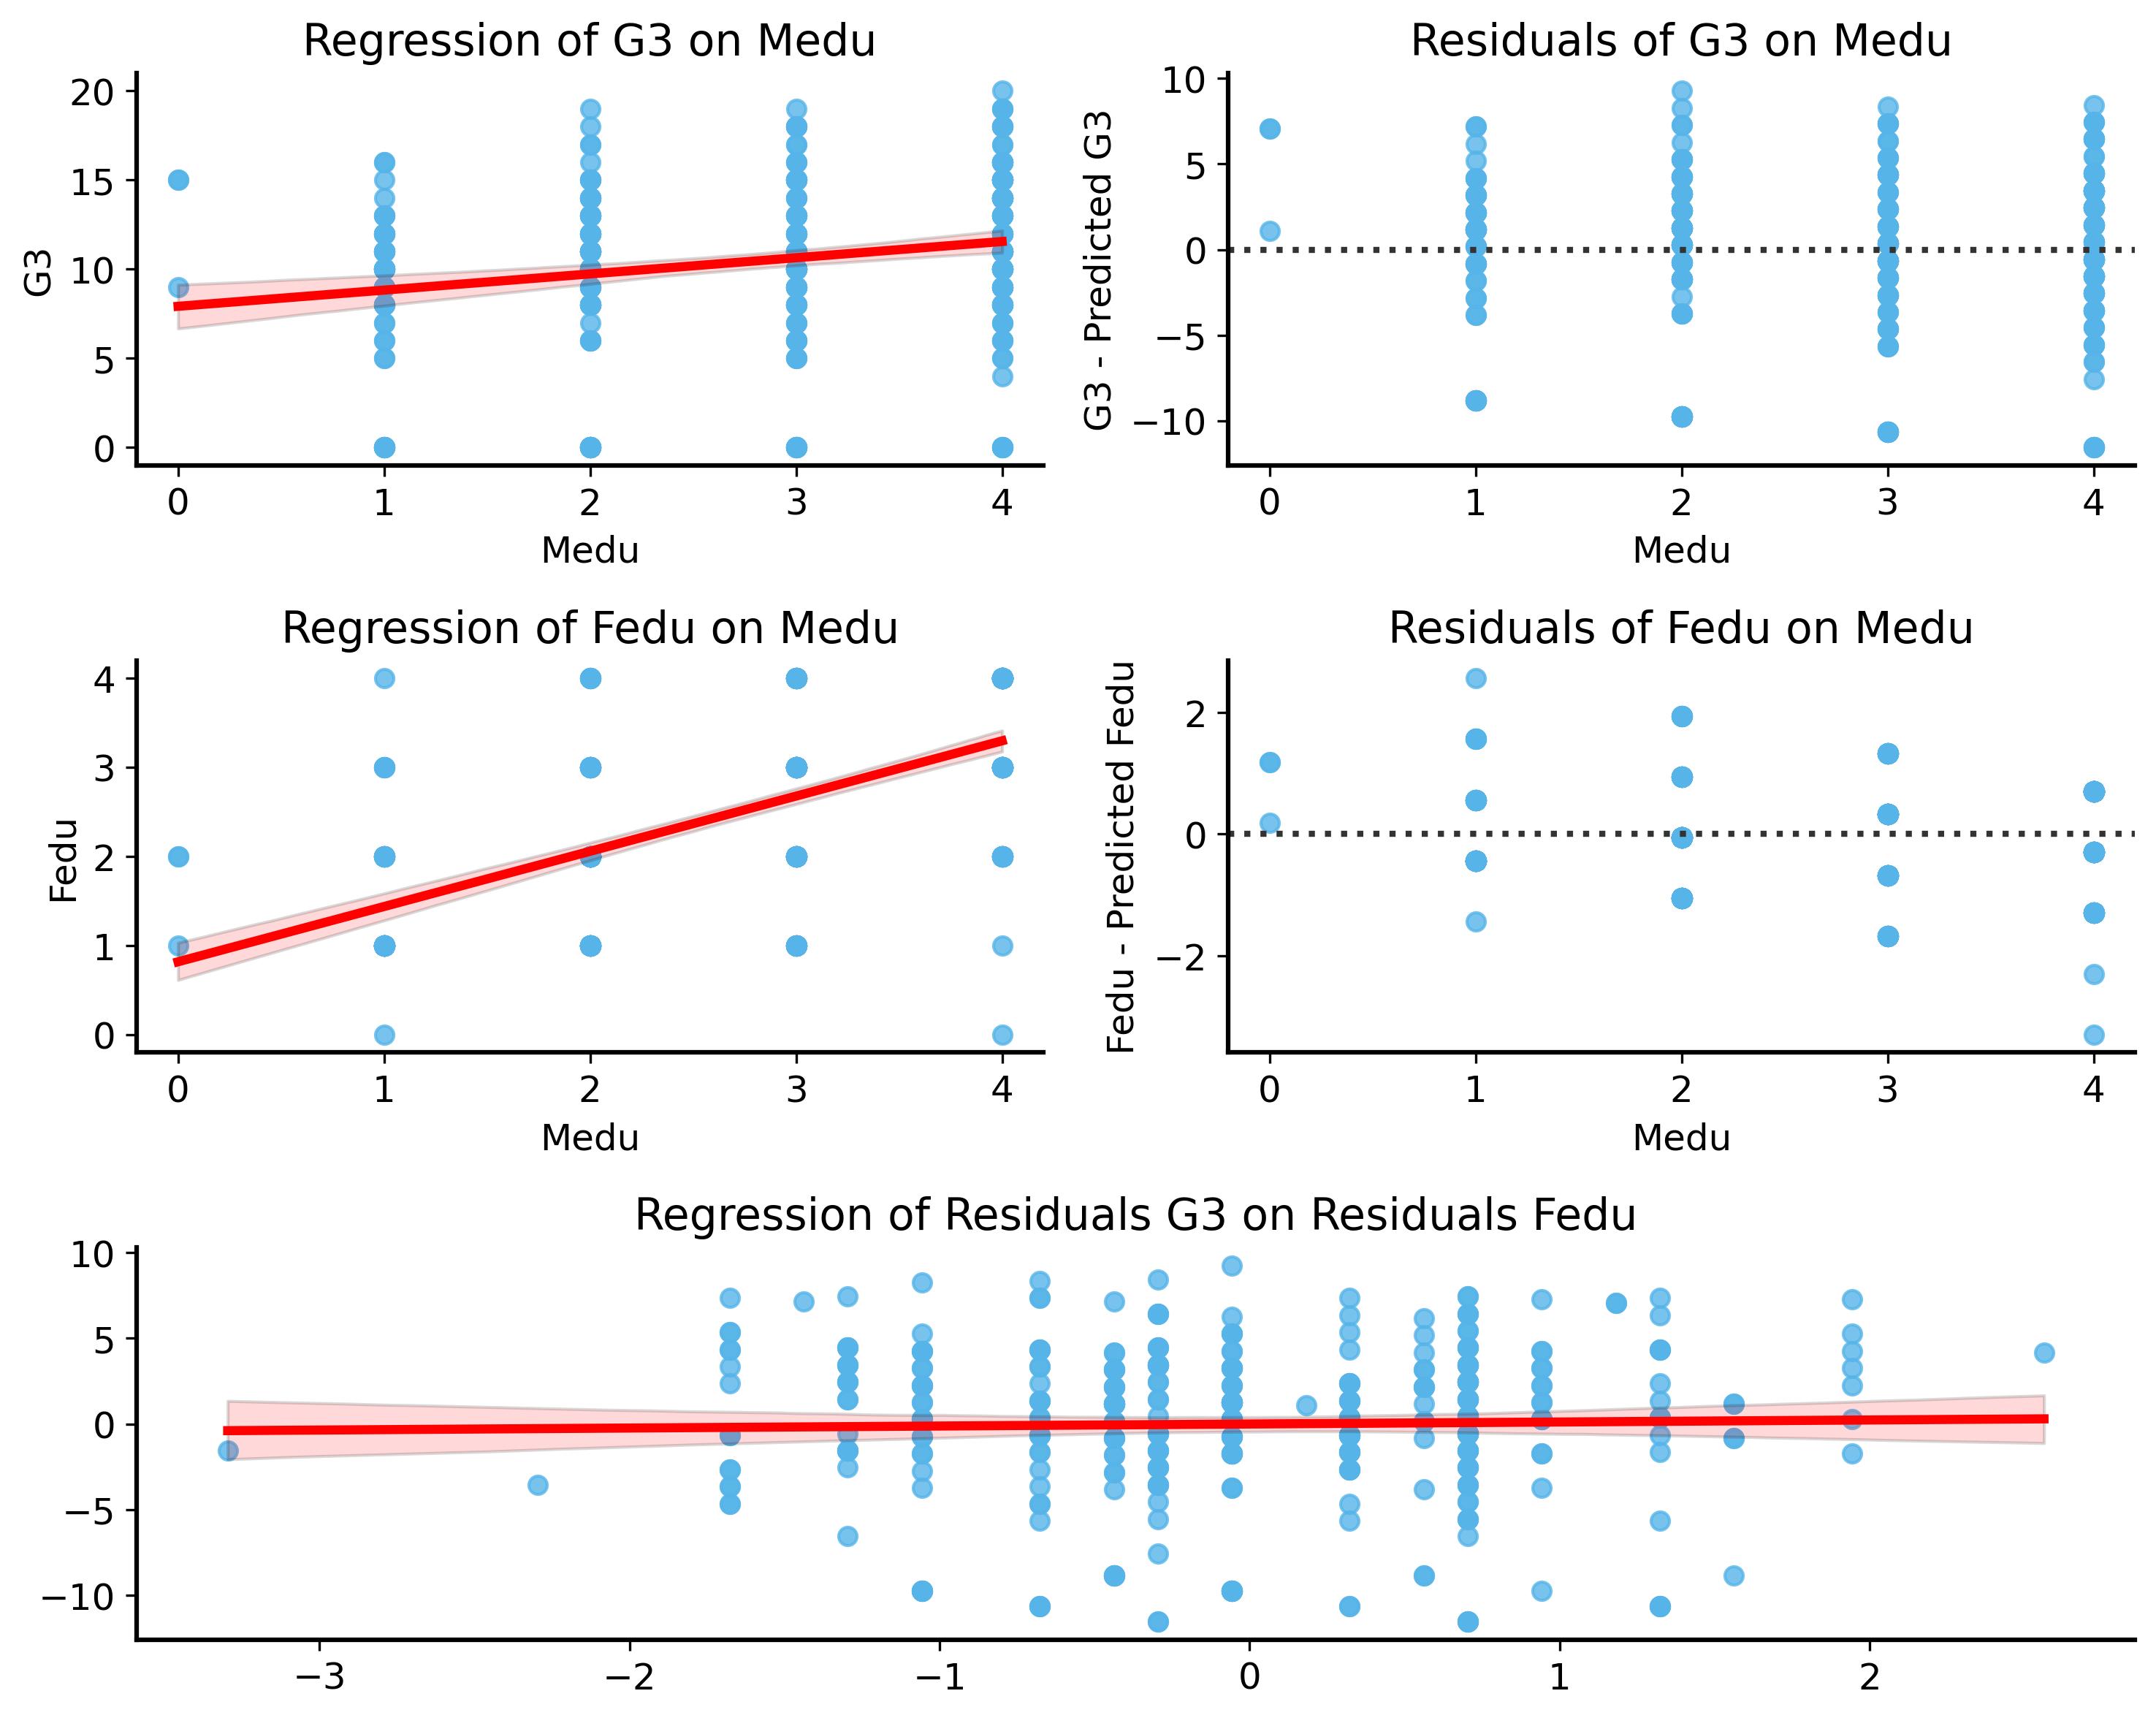

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           residuals_G3   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
No. Observations:                 395   F-statistic:                    0.1968
Covariance Type:            nonrobust   Prob (F-statistic):              0.658
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       9.714e-16      0.225   4.31e-15      1.000      -0.443       0.443
residuals_Fedu     0.1176      0.265      0.444      0.658      -0.404       0.639
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
from statsmodels.formula.api import ols

from matplotlib import gridspec
fig = plt.figure(figsize=(10, 8)); gs = gridspec.GridSpec(3, 2, figure=fig)
# Top 2x2 grid
ax1, ax2, ax3, ax4 = (fig.add_subplot(gs[0, 0]), 
                      fig.add_subplot(gs[0, 1]),
                      fig.add_subplot(gs[1, 0]),
                      fig.add_subplot(gs[1, 1]))
ax5 = fig.add_subplot(gs[2, :])  # bottom row spanning both columns

# regress G3 on Fedu, obtaining the residuals
residuals_G3 = ols("G3 ~ Medu", data=student_data).fit().resid

# plot the regression of G3 on Medu
sns.regplot(x="Medu", y="G3", data=student_data, line_kws={"color": "red"}, ax=ax1)
ax1.set_title("Regression of G3 on Medu")
# plot the residuals of the regression
sns.residplot(x="Medu", y="G3", data=student_data, ax=ax2)
ax2.set_title("Residuals of G3 on Medu")
ax2.set_ylabel("G3 - Predicted G3")

# then regress Fedu on Medu to get the residuals
residuals_Fedu = ols("Fedu ~ Medu", data=student_data).fit().resid
# plot the regression of Fedu on Medu
sns.regplot(x="Medu", y="Fedu", data=student_data, line_kws={"color": "red"}, ax=ax3)
ax3.set_title("Regression of Fedu on Medu")
# plot the residuals of Fedu on Medu
sns.residplot(x="Medu", y="Fedu", data=student_data, ax=ax4)
ax4.set_title("Residuals of Fedu on Medu")
ax4.set_ylabel("Fedu - Predicted Fedu")

# finally, regress the residuals of G3 on the residuals of Fedu
model = ols("residuals_G3 ~ residuals_Fedu", data=pd.DataFrame({
    "residuals_G3": residuals_G3,
    "residuals_Fedu": residuals_Fedu
})).fit()

sns.regplot(x=residuals_Fedu, y=residuals_G3, line_kws={"color": "red"}, ax=ax5)
ax5.set_title("Regression of Residuals G3 on Residuals Fedu")

plt.tight_layout()
plt.show()

# print the summary of the final model
model.summary(slim=True)

The point of this approach is to isolate the effect of `Fedu` on `G3` while controlling for how `Medu` influences both `Fedu` and `G3`.

This probably seems a bit cumbersome. Thankfully, this is exactly what multiple regression does for us! We can fit a multiple regression model with both `Medu` and `Fedu` as predictors of `G3`, and the model will automatically account for the correlation between the predictors.

Below we fit a multiple regression model with `Medu` and `Fedu` as predictors of `G3`, and get exactly the same result for the slope of `Fedu` as we did with the manual approach above.

In [115]:
model = ols("G3 ~ Fedu + Medu", data=student_data).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.043
No. Observations:                 395   F-statistic:                     9.802
Covariance Type:            nonrobust   Prob (F-statistic):           7.01e-05
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.8205      0.648     12.073      0.000       6.547       9.094
Fedu           0.1176      0.265      0.443      0.658      -0.404       0.639
Medu           0.8359      0.264      3.168      0.002       0.317       1.355
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After fitting the multiple regression model, we can see that the coefficient for `Fedu` is much smaller than it was in the simple regression model, and the confidence interval overlaps with zero (meaning there may be no effect). The coefficient for `Medu` is larger, and its confidence interval does not overlap with zero, indicating that it has a significant effect on `G3`. ^[One could make similar statements based on the p-values.]

So, multiple regression allows us to include multiple predictors in our model and account for their simultaneous effects on the response variable. 

It is important to realize that multiple regression does not **solve** the problem of multicollinearity completely. If the predictors are highly correlated with each other, it can still lead to unstable estimates and difficulties in interpretation. Take an extreme example: what if the parents' education levels were perfectly correlated (i.e., for every student, if the father has a certain education level, the mother has exactly the same level)? In this case, we would not be able to distinguish the effects of `Fedu` and `Medu` on `G3` at all. There would be absolutely no data to distinguish between them (specifically, the residuals of `Fedu` on `Medu` would be zero for all students).


## Causality

So does this mean that we can conclude that the Mother's education level causes the student's final grade to increase? 

Not necessarily. For instance, it could be both parents' education levels and a student's final grade are influenced by a third variable, such as the family's socioeconomic status. Meaning, more wealthy families can afford continuing education for their children across generations, and this leads to both higher parental education levels and better student performance (through tutoring and other resources).

This is the reason for the common adage in statistics: **correlation does not imply causation**. Just because two variables are correlated does not mean that one causes the other.

There are two main reasons why correlation does not imply causation:

1. **Confounding Variables**: There may be a third variable that influences both variables, leading to a spurious correlation between them. The above example of parental education and student performance is an example of this. In the regression model we fit earlier, the mother's education level `Medu` was a confounding variable that influenced both the father's education level `Fedu` and the student's final grade `G3`.
2. **Reverse Causation**: The relationship could be reversed, meaning that the second variable causes the first, rather than the other way around. In our student performance example, it is quite unlikely that the student's final grade causes the parents' education levels to change (we know this is not possible), but one could easily fit a regression model that suggests this is the case if we were not careful.

To drive home this second point, let's do that:

In [117]:
from statsmodels.formula.api import ols
model = ols("Medu ~ Fedu + G3", data=student_data).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Medu   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.401
No. Observations:                 395   F-statistic:                     132.8
Covariance Type:            nonrobust   Prob (F-statistic):           9.00e-45
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9051      0.136      6.658      0.000       0.638       1.172
Fedu           0.6080      0.040     15.319      0.000       0.530       0.686
G3             0.0299      0.009      3.168      0.002       0.011       0.048
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression model suggests that the student's final grade `G3` causes the mother's education level `Medu` to increase. Without inventing a time machine, we know this is not possible.

### Including Confounding Variables in Regression
Luckily for us, some of these problems can be mitigated by including confounding variables in our regression model. We saw an example of this earlier when we included both `Medu` and `Fedu` as predictors of `G3`. The problem is that the regression model does not automatically tell us which variable is the cause and which is the effect. It only tells us how the variables are related to each other.

To determine causality, we need to use additional methods such as randomized controlled trials (RCTs), or more advanced statistical techniques that we're not going to cover in this course. 

### Randomized Controlled Trials (RCTs)

RCTs are considered the gold standard for establishing causality. In an RCT, participants are randomly assigned to either a treatment group (which receives the intervention) or a control group (which does not receive the intervention). This randomization helps to eliminate confounding variables and ensures that any differences in outcomes between the groups can be attributed to the treatment itself. 

Think about it this way: if we randomly assigned students to different levels of parental education (e.g., some students have educated parents, while others do not), then we could directly measure the effect of parental education on student performance without worrying about confounding variables (like how wealthy the family is). 

Unfortunately, RCTs are not always feasible or ethical in practice. For example, we cannot randomly assign students to different families or change their parental education levels. In such cases, we must rely on observational data and statistical techniques to infer causality, while being aware of the limitations and potential biases in our analyses.
